# Проект временные ряды

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# План проекта
[1. Подготовка данных](#section1)<br>
[2. Анализ данных](#section2)<br>
[3. Обучение моделей](#section3)<br>
&nbsp;&nbsp;&nbsp;[3.1 Линейная регрессия](#section3.1)<br>
&nbsp;&nbsp;&nbsp;[3.2 LigthBoost](#section3.2)<br>
[4. Тестирование](#section4)<br>
[5. Вывод](#section5)<br>

Импорт необходимых библиотек

In [3]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
# библиотеки алгоритмов машшиного обучения
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge
# библиотеки работы с файлами
from pathlib import Path
import os
from urllib.request import urlretrieve
# библиотеки графики
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
# прочее
import warnings
warnings.filterwarnings('ignore')

Вспомогательные функции

In [4]:
def get_file(file_name, url):
    """
    Функция проверяет есть локально файл с данными, если нет скачивает по ссылки из Инета
    Параметры:
    file_name - полный путь к файлу
    url - ссылка из Инета 
    """
    #проверка есть ли файл
    if not os.path.exists(file_name):
        print(file_name,'файл не найден и будет скачен по сети')
        urlretrieve(url,file_name)

def show_time_series(series, title):
    '''
        Построение графиков временных рядов
        Параметры:
        series - ряд, индекс дататайм
        
    ''' 
    series.plot(figsize=(15,7),title=title,grid=True)
    
def make_features(data, max_lag, rolling_mean_size):
    '''
        Функция добавляет новые признаки
    '''
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

def plot_feature_impotance(model, columns , title):
    """
    Вывод графика по анализу признаков
    Параметры:
    - model - модель LigthGBM или CatBoost
    - columns - список признаков
    - title - заголовок графика
    """
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False))
    plt.title(title)
    plt.show()

# 1. Подготовка
<a id='section1'></a>

In [5]:
# загрузка данных
Path('datasets').mkdir(parents=True,exist_ok=True)
urls = {
    'taxi':('datasets\\taxi.csv','https://code.s3.yandex.net/datasets/taxi.csv'),
}
[get_file(*urls[k]) for k in urls]
data = pd.read_csv(urls['taxi'][0],index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

datasets\taxi.csv файл не найден и будет скачен по сети


In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Пропусков нет. Преобразование типов не требуется. Данные предоставлены за период с 01.03.2018 по 31.08.2018

# 2. Анализ
<a id='section2'></a>

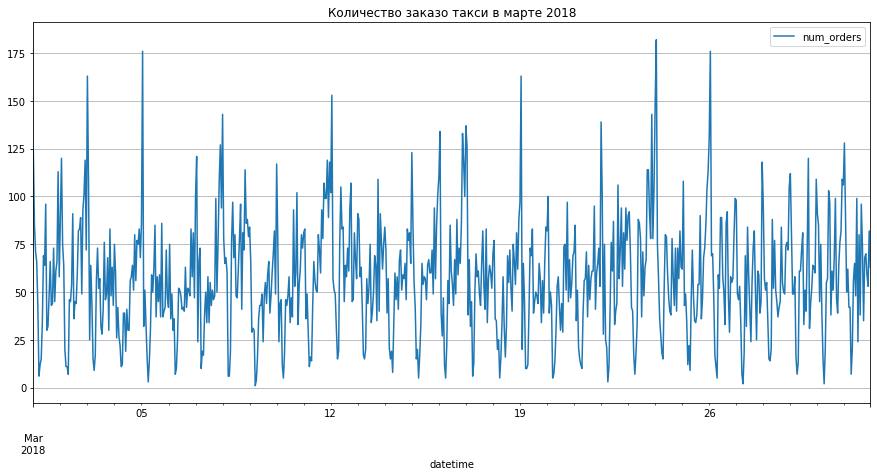

In [8]:
show_time_series(data['2018-03-01':'2018-03-31'],title='Количество заказо такси в марте 2018')

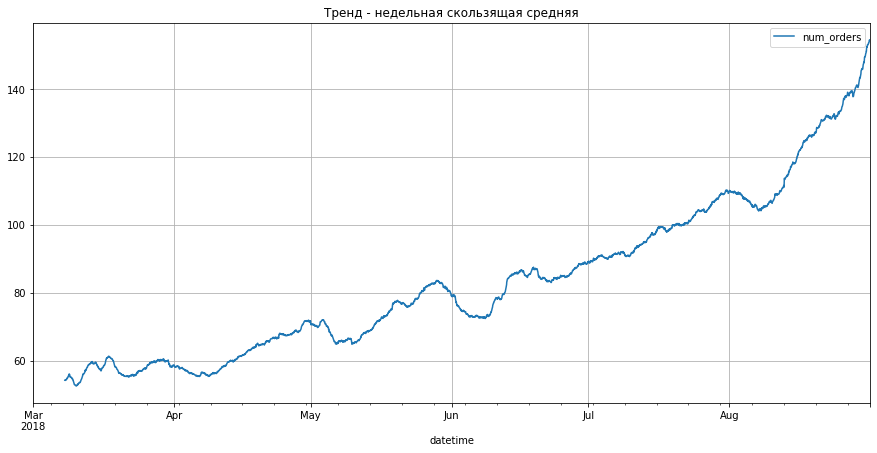

In [9]:
show_time_series(data.rolling(168).mean(),title='Тренд - недельная скользящая средняя')

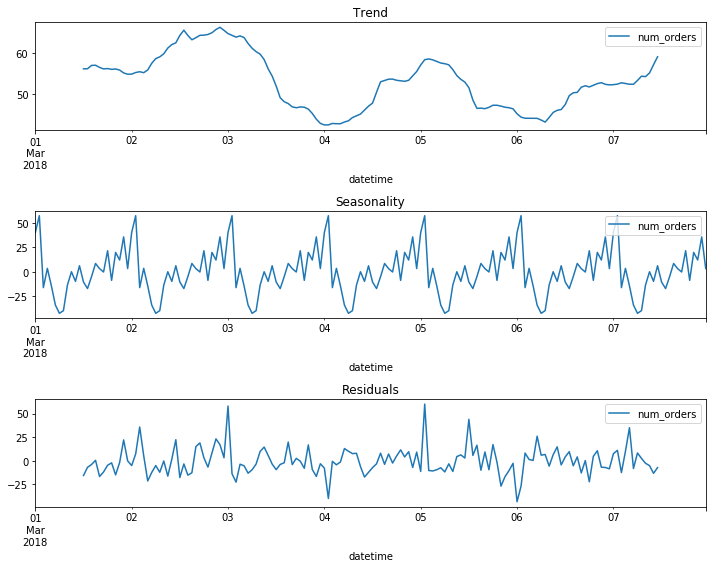

In [10]:
# расмотри одну неделю данных
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-07'])
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Вывод:
<br>
В данных есть возрастающий тренд и суточная периодичность, также вероятно количество заказов меняется будни/выходные. Учтем это при построении признаков для обучения.

# 3. Обучение
<a id='section3'></a>

In [11]:
make_features(data, 6, 168)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

cv_split = TimeSeriesSplit(n_splits=10)

## 3.1 Линейная регрессия
<a id='section3.1'></a>

In [12]:
%%time
lr = Ridge()
parameters = {
    'alpha': [0.01,0.1,0.5,0.9]
}
grid = RandomizedSearchCV(lr,parameters,verbose=1,cv=cv_split,n_jobs = -1)
grid.fit(train.drop('num_orders',axis=1),train['num_orders'])

print('Ridge regression best parametrs = ', grid.best_params_)
ridge_regression_best_model = grid.best_estimator_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge regression best parametrs =  {'alpha': 0.9}
CPU times: user 331 ms, sys: 361 ms, total: 692 ms
Wall time: 665 ms


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.7s finished


## 3.2 LigthBoost
<a id='section3.2'></a>

In [13]:
%%time
model = lgb.LGBMRegressor(metric='rmse')
# общие параметры
parameters = {
    'n_estimators': [10, 100, 500],
    'num_leaves': [10, 100, 500],
    'max_depth': [6,12,24],
    'learning_rate' : [0.01, 0.05, 0.1, 0.5]
}
train_ligthGBM = train.copy()
test_ligthGBM = test.copy()
for column in ['day','dayofweek','hour']: 
    train_ligthGBM[column] = train_ligthGBM[column].astype('category')
    test_ligthGBM[column] = test_ligthGBM[column].astype('category')

grid = RandomizedSearchCV(model,parameters,verbose=1,cv=cv_split,n_jobs = -1)
grid.fit(train_ligthGBM.drop('num_orders',axis=1),train_ligthGBM['num_orders'])

print('LigthBoost best parametrs = ', grid.best_params_)
ligthboost_best_model = grid.best_estimator_

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.2min finished


LigthBoost best parametrs =  {'num_leaves': 100, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.05}
CPU times: user 2min 10s, sys: 1.8 s, total: 2min 12s
Wall time: 2min 13s


# 4. Тестирование
<a id='section4'></a>

In [14]:
ridge_regression_best_model.fit(train.drop('num_orders',axis=1),train['num_orders'])
y_pred_ridge = ridge_regression_best_model.predict(test.drop('num_orders',axis=1))
print("RSME ridge regression тестовой выборки: ", np.sqrt(MSE(y_pred_ridge,test['num_orders'])))

ligthboost_best_model.fit(train_ligthGBM.drop('num_orders',axis=1),train_ligthGBM['num_orders'])
y_pred_ligthboost = ligthboost_best_model.predict(test_ligthGBM.drop('num_orders',axis=1))
print("RSME ligthboost тестовой выборки: ", np.sqrt(MSE(y_pred_ligthboost,test['num_orders'])))

RSME ridge regression тестовой выборки:  49.85324105839393
RSME ligthboost тестовой выборки:  40.54491462071721


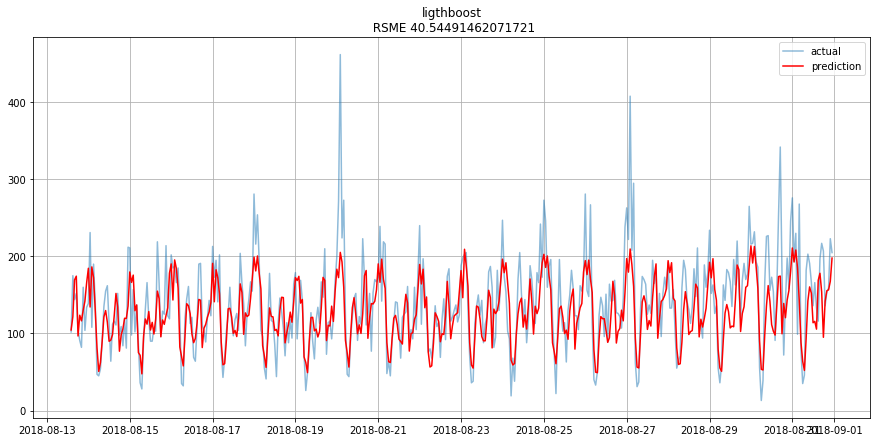

In [15]:
# отобразим исходные данные и предсказания на тестовой выборке
plt.figure(figsize=(15, 7))
plt.plot(test['num_orders'],alpha=0.5, label="actual")
plt.plot(pd.Series(y_pred_ligthboost,test.index), "r", label="prediction")
plt.legend(loc="best")
plt.title("ligthboost\n RSME {}".format(np.sqrt(MSE(y_pred_ligthboost,test['num_orders']))))
plt.grid(True)

Исследуем важность признаков

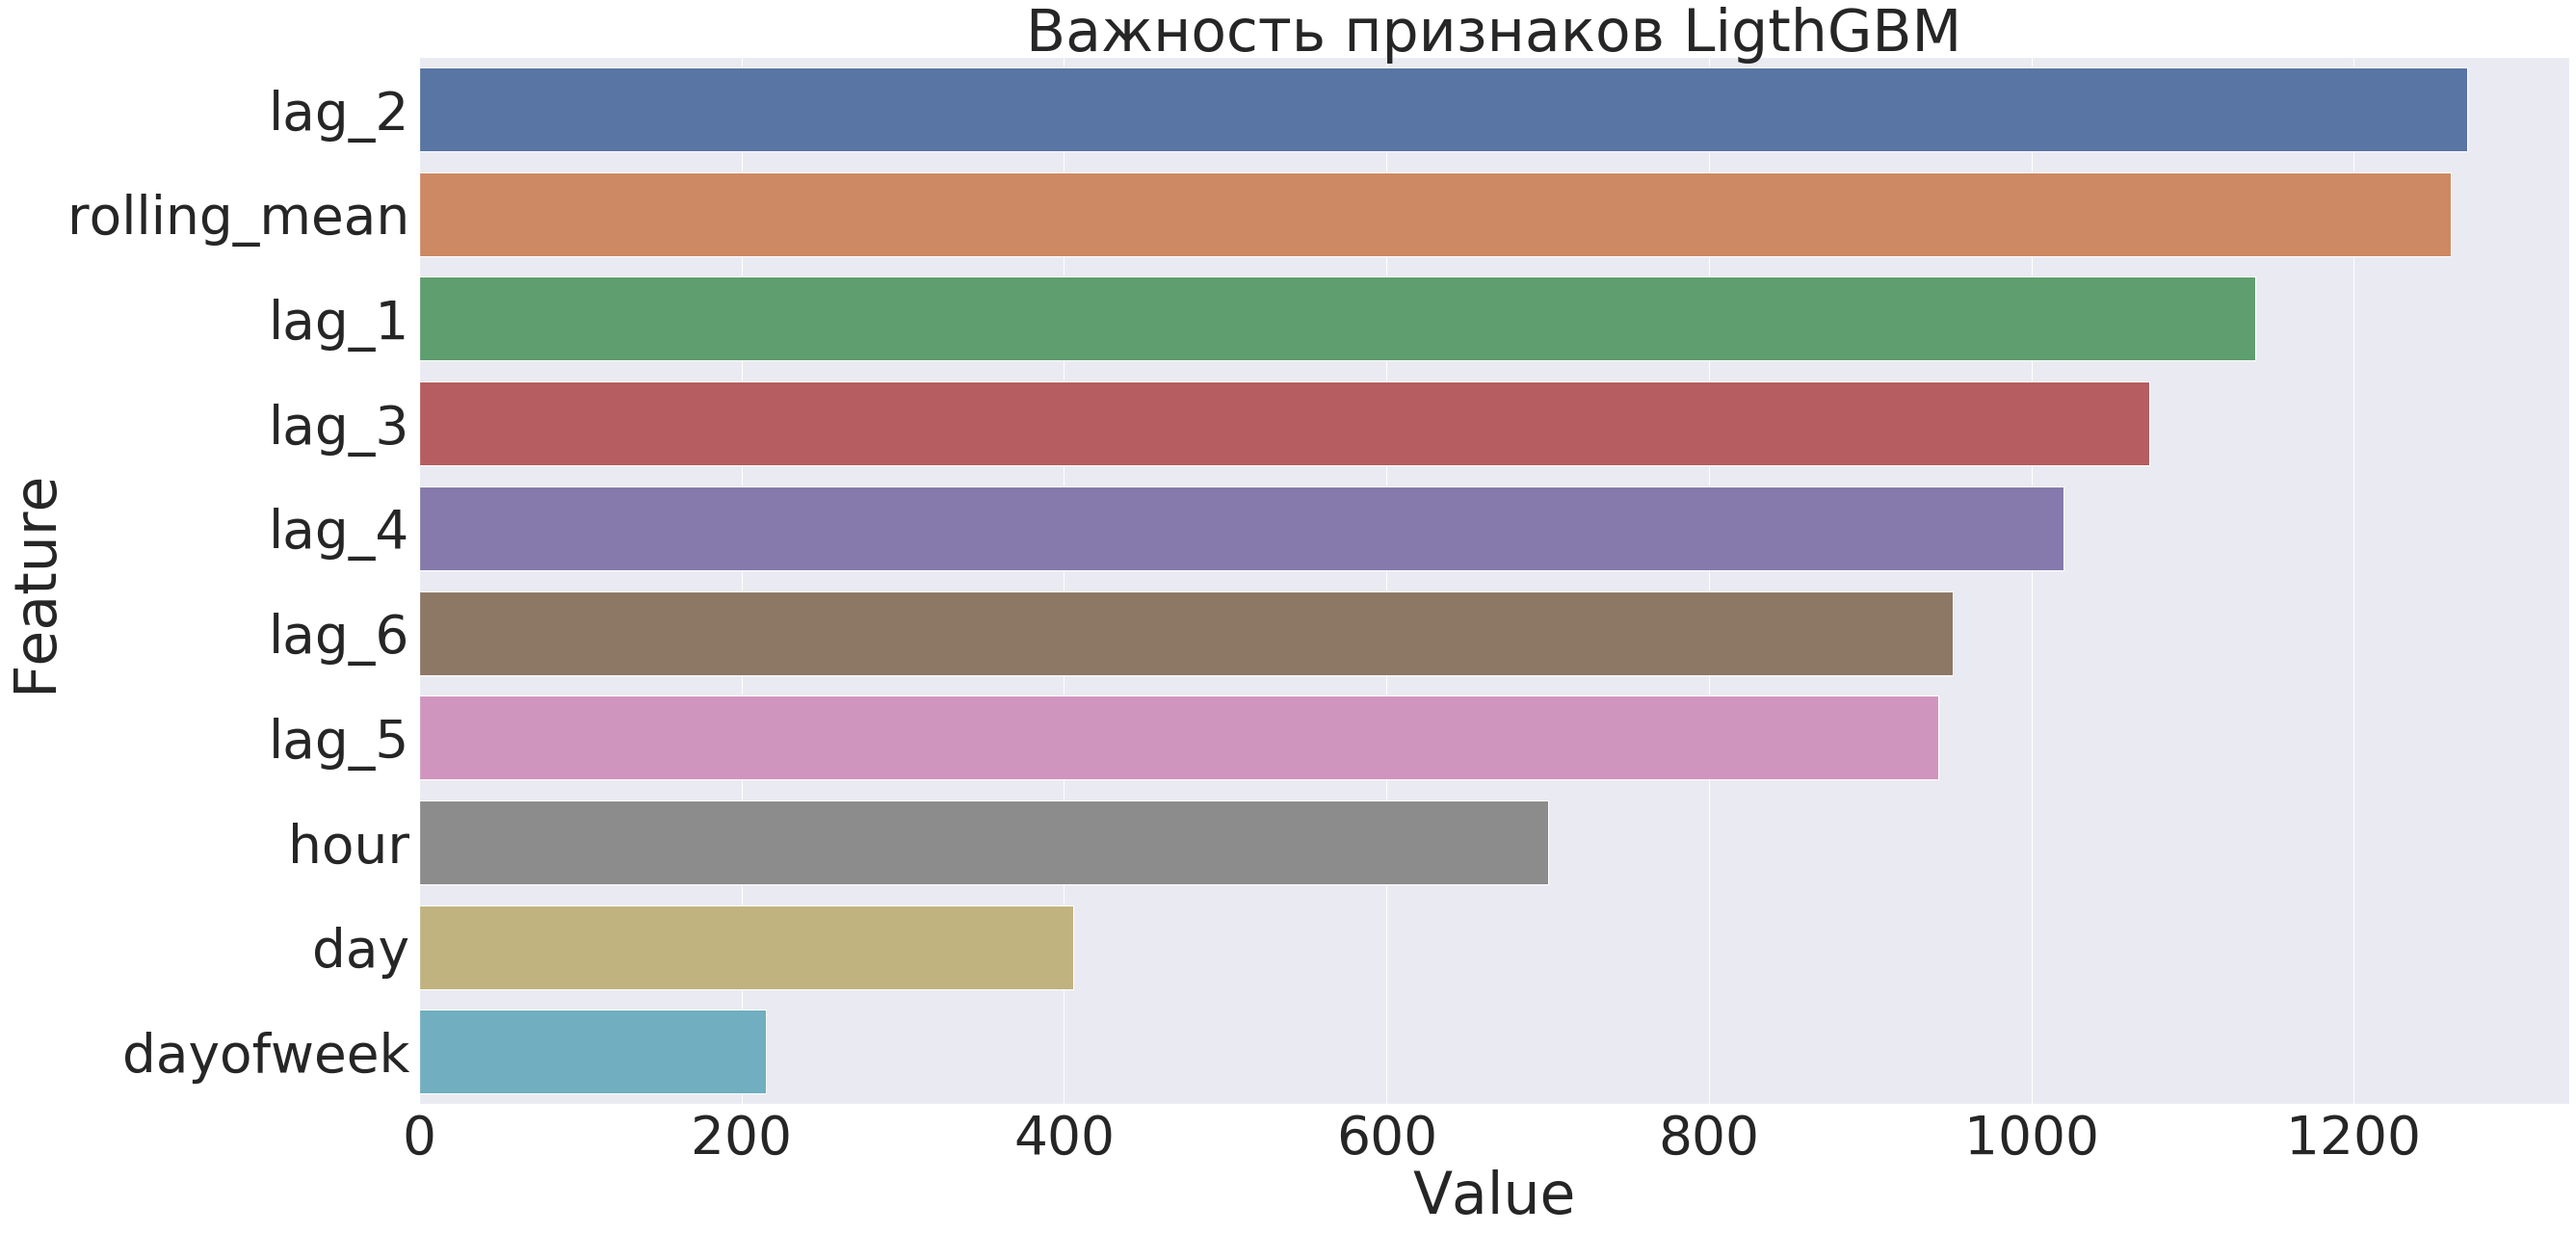

In [16]:
plot_feature_impotance(ligthboost_best_model,train_ligthGBM.drop('num_orders',axis=1).columns,title='Важность признаков LigthGBM')

# Вывод
<a id='section5'></a>
<br>
При анализе данных были выявленны тренд в данных и суточная периодичность. Для предсказания мы преминили модель на основе линейной регрессии и ансамбль моделей из библиотеки ligthboost. Модель на основе ансамбля моделей показывает лучшие результаты. Наша лучшая модель не плохо предсказывает суточные колебания, но плохо предсказывает пиковые нагрузки. В качестве самых важных признаков модель выделяет: тренд и предыдущее значения временного ряда.

В качестве рекомендаций по развитию модели можно предложить следующее увеличить лаг до 24 (так как для предсказания 18:00 сегодня, будет полезным 18:00 вчера) или до 168 часов - неделя.